In [2]:
import numpy as np
from numpy.fft import fft2, fft, ifft, ifft2

# mistakes: 
# giving fft input 2d array
# arrange instead of arange
# shapes
# variables easily get reassigned

In [3]:
N = 10
x = np.random.random(N).reshape((N//2, 2))
x

array([[0.62742096, 0.99688546],
       [0.11026334, 0.48579521],
       [0.20074066, 0.06138322],
       [0.01232202, 0.25929843],
       [0.75164455, 0.52114716]])

### axis enumeration:
axis=0   is up/down, ei. change of rows

axis=1   is left/right, ei. change of cols

In [5]:
res2 = fft2(x)
print(res2)


[[ 5.94084215+0.j          2.17920322+0.j        ]
 [-0.2528166 +0.34957788j  0.26716904+0.60786069j]
 [ 0.426519  +1.04893442j  0.16166223-0.61512707j]
 [ 0.426519  -1.04893442j  0.16166223+0.61512707j]
 [-0.2528166 -0.34957788j  0.26716904-0.60786069j]]


fft2 can be calculated by
first applying fft on each matrix row
then applying fft on that

In [7]:
# slower onEachRow = np.apply_along_axis(func1d=myfunc, axis=1, arr=x)
onEachRow = fft(x, axis=1)
#print(onEachRow)

# slower onEachCol = np.apply_along_axis(func1d=myfunc, axis=0, arr=onEachRow)
# np.apply_along_axis is slower because it uses python loops under the hood
onEachCol = fft(onEachRow, axis=0)
print(onEachCol)
print("good results? ", np.allclose(onEachCol, res2))

[[ 5.94084215+0.j          2.17920322+0.j        ]
 [-0.2528166 +0.34957788j  0.26716904+0.60786069j]
 [ 0.426519  +1.04893442j  0.16166223-0.61512707j]
 [ 0.426519  -1.04893442j  0.16166223+0.61512707j]
 [-0.2528166 -0.34957788j  0.26716904-0.60786069j]]
good results?  True


In [4]:
def myfft2(x):
    ''' Computes 2d fft using numpys fft '''
    onEachRow = fft(x, axis=1)
    return fft(onEachRow, axis=0)


In [97]:
t = np.arange(1000).reshape(10,100)
%timeit f2 = fft2(t)
print('myfft2 is faster than fft2, but only at sub 10k lens')
%timeit f1 = myfft2(t)
print(np.allclose(myfft2(t), fft2(t)))

54.6 µs ± 3.99 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
myfft2 is faster than fft2, but only at sub 10k lens
38.7 µs ± 486 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
True


In [5]:
def myfft_bad(x):
    #x = x.astype(float)
    N = x.shape[0]
    n = np.arange(N).reshape((N,1))
    k = n.reshape((1,N))
    # k and n make an N x N matrix of 
    # complex coefficients that get multiplied with x
    Mat = np.exp(np.pi * k * n/ N * -2j)
    return np.dot(Mat, x)

In [6]:
t=np.arange(4000)

v1 = myfft_bad(t)
v2 = fft(t)
#print("they're insignificantly differenc",v1-v2)
np.allclose(v1,v2)

True

In [122]:
# at len(t)=3000 myff_bad takes 614ms, and at 4k it takes 1.1s
# while np.fft only takes 63µs 
%timeit myfft_bad(t)
%timeit fft(t)
print('myfft_bad is a lot slower than npfft')
print('myfft_bad has O(N^2) numerical operations while np.fft has O(NlogN)')

1.09 s ± 4.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
62.8 µs ± 222 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
myfft_bad is a lot slower than npfft
myfft_bad has O(N^2) numerical operations while np.fft has O(NlogN)


In [7]:
#testing types
test = np.array([1,2,3])
test2 = test.astype(float)
print(test.dtype)
print(test2.dtype)

a = test.reshape(3,1)
print(a.shape)
a = test.reshape((3,1))
print(a.shape)

arr = np.arange(10)
print(arr.shape)
arr = np.arange(10).reshape(10,1)
print(arr.shape)

n = np.arange(10)
k = n.reshape((10, 1))
#print(n*k)
n = np.arange(10).reshape((10,1))
k = n.T
#print(n*k)
#print(n*n.T)

int32
float64
(3, 1)
(3, 1)
(10,)
(10, 1)


In [14]:
def myfft_better(x):
    ''' Cooley Tukey FFT, only works for lenghts that are power of 2 '''
    #x = x.astype(float)
    N = x.shape[0]
    
    if N % 2 != 0:
        raise Exception("Error, len(x) has to be power of 2")
    if N <= 8: # at some point it's better to fall back to the basic algorithm
        return myfft_bad(x)
    even = myfft_better(x[::2])
    odd = myfft_better(x[1::2])
    multiplier = np.exp( np.pi * np.arange(N) / N * -2j)
    return np.concatenate([even + multiplier[:N//2] * odd, 
        even + multiplier[N//2:] * odd])


In [56]:
t=np.arange(4096)

v1 = myfft_better(t)
v2 = fft(t)
#print("they're insignificantly differenc",v1-v2)
np.allclose(v1,v2)

True

In [43]:
%timeit myfft_bad(t)
%timeit myfft_better(t)
%timeit fft(t)
print("myfft is still slower, but orders of magnitute faster than the other implementation")
print("len(t)=4096")
print("N=64 -> 17ms, N=32 -> 10ms, N=16 -> 9.5ms, N=8 -> 12.2ms")

1.13 s ± 7.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
12.5 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
59 µs ± 298 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
myfft is still slower, but orders of magnitute faster than the other implementation
N=64 -> 17ms, N=32 -> 10ms, N=16 -> 9.5ms, N=8 -> 12.2ms


In [205]:
def my2dfft(x):
    onEachRow = np.apply_along_axis(myfft_better, 1, x)
    return np.apply_along_axis(myfft_better, 0, onEachRow)

In [604]:
t=np.random.rand(4096).reshape(512,8)

v1 = fft2(t)
v2 = my2dfft(t)
#print("they're insignificantly differenc",v1-v2)
np.allclose(v1,v2)

True

In [214]:
s = 256
t=np.arange(s*s).reshape(s,s)
%timeit myfft2(t)
%timeit my2dfft(t)
%timeit fft2(t)

print('a lot slower than the fortrans fft2 implementation, but useable')
print('N=512x512 -> my2dfft 1s')

2.35 ms ± 45.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
334 ms ± 3.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.34 ms ± 45.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a lot slower than the fortrans fft2 implementation, but useable
N=512x512 -> my2dfft 1s


In [613]:
print('''Problem with the last implementation of fft is that on each node in the
recursive tree the same vector is constructed and multiplied with given input,
it would be a lot faster if it could be vectorized. And it can be!''')
def myfft_best(x):
    ''' vectorized Cooley Tukey, not recursive'''
    N = x.shape[0]
    #print(N)
    # hacky way of checking if a number is power of two
    # faster than log checking and not error prone
    if not ( ((N & (N - 1)) == 0) and N > 0 ):
        raise Exception("Error, len(x) has to be power of 2")
    
    # chungs of input onto which to apply the same multiplication
    sliceSize = min(N, 64)
    
    #One shape dimension can be -1. In this case, 
    #the value is inferred from the length of the array and remaining dimensions.
    xslices = x.reshape(sliceSize, -1)
    
    # applying calculation of myfft_bad on all slices
    n = np.arange(sliceSize)
    # in numpy None at index creates an axis with length 1.
    k = n[:, np.newaxis]
    factors = np.exp(np.pi * k * n/sliceSize * -2j)
    X = np.dot(factors, xslices)
    #print(X.shape[0])

    while N > X.shape[0]:
        #analogous to even/odd in myfft_better
        firstHalf = X[:, :X.shape[1]//2]
        secondHalf = X[:,  X.shape[1]//2:]
        Nvec = np.arange(X.shape[0])
        factor = np.exp(np.pi * Nvec / X.shape[0] * -1j)[:, np.newaxis]
        X = np.vstack([
            firstHalf + factor * secondHalf,
            firstHalf - factor * secondHalf
        ])
        #print('N',N)
        #print('X.shape[0]',X.shape[0])
    
    # reshape it to be same as input vector
    return X.reshape(N)

Problem with the last implementation of fft is that on each node in the
recursive tree the same vector is constructed and multiplied with given input,
it would be a lot faster if it could be vectorized. And it can be!


In [615]:
t=np.random.rand(128)
np.allclose(v1,v2)
v1 = fft(t)
v2 = myfft_best(t)
#print(v1)
#print(v2)


In [587]:
def my2dfft_better(x):
    onEachRow = np.apply_along_axis(myfft_best, 1, x)
    return np.apply_along_axis(myfft_best, 0, onEachRow)

In [617]:
s = 128
t=(np.random.randn(s*s) *255).reshape(s,s)

v1 = fft2(t)
v2 = my2dfft_better(t)
print(np.allclose(v1,v2))
print(v1.shape, v2.shape)
print('v1',v1[0:10,0])
print('v2',v2[0:10,0])


True
(128, 128) (128, 128)
v1 [-25693.47676       +0.j         -38902.39559232+43272.61210629j
  -9844.10646023-11944.11369794j  -2192.28599306 +2644.99990156j
  -1023.89570906 +6673.60516903j  18201.97999707-19159.01510706j
 -21048.31536237-25913.32528308j  16430.24425776 -9579.69431101j
  16419.93811086-22116.2664523j  -22268.10659491-44336.17337245j]
v2 [-25693.47676       +0.j         -38902.39559232+43272.61210629j
  -9844.10646023-11944.11369794j  -2192.28599306 +2644.99990156j
  -1023.89570906 +6673.60516903j  18201.97999707-19159.01510706j
 -21048.31536237-25913.32528308j  16430.24425776 -9579.69431101j
  16419.93811086-22116.2664523j  -22268.10659491-44336.17337245j]


In [618]:
print('''my2dfft_better is much faster than earlier implementation,
numpys fft2 is still better of course.''')
s = 512
t=np.arange(s*s).reshape(s,s)
%timeit my2dfft_better(t)
%timeit my2dfft(t)
%timeit fft2(t)



my2dfft_better is much faster than earlier implementation,
numpys fft2 is still better of course.
303 ms ± 2.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.41 s ± 3.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
12.1 ms ± 144 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [605]:
# https://www.dsprelated.com/showarticle/800.php
def myifft(x):
    #method#3, for some reason it doesn't work
#     real = x.real
#     x.real = x.imag
#     x.imag = real
#     y = myfft_better(x)
#     real = y.real
#     y.real = y.imag
#     y.imag = real
#     return y / y.shape[0]
    # method#4, works well
    x.imag *= -1
    y = myfft_better(x)
    y.imag *= -1
    return y / y.shape[0]

In [606]:
x = np.arange(16)
f = fft(x)
print(np.allclose(ifft(f), myifft(f)))
print(ifft(f))
print(myifft(f))

True
[ 0.+0.00000000e+00j 15.+1.13242749e-14j 14.+9.42545333e-15j
 13.+1.03250741e-14j 12.+2.22044605e-16j 11.+3.33066907e-15j
 10.+3.00904454e-15j  9.+3.88578059e-15j  8.+0.00000000e+00j
  7.-4.66293670e-15j  6.-3.00904454e-15j  5.-4.32986980e-15j
  4.-2.22044605e-16j  3.-9.99200722e-15j  2.-9.42545333e-15j
  1.-9.88098492e-15j]
[ 0.+6.66133815e-16j 15.+7.94738930e-15j 14.+3.43999064e-15j
 13.+4.36876431e-15j 12.-2.26621556e-15j 11.-1.02576502e-16j
 10.+1.86519211e-15j  9.-1.44558843e-15j  8.-7.11903325e-16j
  7.-3.37688556e-15j  6.-1.00090146e-15j  5.+8.16050634e-16j
  4.+1.82212635e-15j  3.-6.09778084e-15j  2.-7.01659209e-15j
  1.+1.09889094e-14j]


In [607]:
# inverse calculations from fft2
def myifft2(x):
    onEachRow = np.apply_along_axis(myifft, 1, x)
    onEachCol =  np.apply_along_axis(myifft, 0, onEachRow)
    return onEachCol #.real

In [608]:
x = np.random.randn(16).reshape(4,4)
f = fft2(x)
print(np.allclose(ifft2(f), myifft2(f)))
print(ifft2(f))
print(myifft2(f))

True
[[ 0.95943023+0.j -0.31720884+0.j  0.34635935+0.j  1.36654216+0.j]
 [-1.30921478+0.j -1.68860856+0.j -1.31463342+0.j  0.88945894+0.j]
 [ 0.72521477+0.j  0.77629329+0.j  0.53349589+0.j -1.02334405+0.j]
 [ 0.64281388+0.j -0.7889555 +0.j -0.1751325 -0.j  0.63588062+0.j]]
[[ 0.95943023-0.00000000e+00j -0.31720884+1.34450484e-16j
   0.34635935-4.67319551e-18j  1.36654216-2.69249961e-16j]
 [-1.30921478+1.91507303e-16j -1.68860856+2.49120319e-16j
  -1.31463342+2.50416383e-16j  0.88945894-6.96715327e-16j]
 [ 0.72521477-1.15276921e-16j  0.77629329-4.01327368e-16j
   0.53349589-1.72688260e-16j -1.02334405+8.17456942e-16j]
 [ 0.64281388-1.42641785e-16j -0.7889555 +2.08586729e-16j
  -0.1751325 +7.47832370e-17j  0.63588062-2.62902629e-16j]]


The formula of a Gaussian function in one dimension is
$$G(x) = \frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{x^2}{2 \sigma^2}}$$
In two dimensions, it is the product of two such Gaussian functions, one in each dimension:
$$G(x,y) = \frac{1}{{2\pi \sigma^2}} e^{- \frac{x^2 + y^2}{2 \sigma^2}}$$

In [620]:
# program implementation
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from scipy import ndimage
import math
import matplotlib.pyplot as plt

def getGaussMatrix(numRows, numCols, sigma, saveLowFreq):
    centerI = numRows//2 + 1 if numRows % 2 == 1 else numRows//2
    centerJ = numCols//2 + 1 if numCols % 2 == 1 else numCols//2

    def gaussian(i,j):
        coefficient = math.exp(-1.0 * ((i - centerI)**2 + (j - centerJ)**2) / (2 * sigma**2))
        return coefficient if saveLowFreq else 1 - coefficient
    
    G = numpy.array([[gaussian(i,j) for j in range(numCols)] for i in range(numRows)])
    #showImg(G)
    return G
 
def applyFilterOnDFT(imageMatrix, filterMatrix, useNpFunc):
    '''converts to dft, applies filterMatrix, then inverts dft'''
    #shiftedDFT = v1 = fftshift(fft2(imageMatrix))
    #v2 = fftshift(my2dfft_better(imageMatrix))
    #print('fft.allclose:',np.allclose(v1,v2))
    #print("shapes:", v1.shape, v2.shape)
    shiftedDFT = fftshift(fft2(imageMatrix)) if useNpFunc else \
       fftshift(my2dfft_better(imageMatrix))

    filteredDFT = shiftedDFT * filterMatrix
#     print("real:")
#     showImg(filteredDFT.real)
#     print("complex:")
#     showImg(filteredDFT.imag)

    #plt.imshow(filteredDFT.real, cmap='gray')
    #plt.show()
    
#     res = v1 =  ifft2(ifftshift(filteredDFT))
#     v2 = myifft2(ifftshift(filteredDFT))
#     print('ifft.allclose:',np.allclose(v1,v2))

    res = ifft2(ifftshift(filteredDFT)) if useNpFunc else \
       myifft2(ifftshift(filteredDFT))

    return res

def removeFreq(image, sigma, useNumpyDFT, highFreq=True):
    ''' if highFreq=True - filters out high freqs and passes low freqs 
    if highFreq=False - filters out low freqs and passes highFreqs'''
    (h,w) = image.shape
    G = getGaussMatrix(h, w, sigma, highFreq)
    return applyFilterOnDFT(image, G, useNumpyDFT)

def hybridImage(highFreqImg, lowFreqImg, sigmaHigh, sigmaLow, highOverLow=1.0, useNumpyDFT=True):
    '''combines high freq of one image with low freq of other image'''
    highFreq = removeFreq(highFreqImg, sigmaHigh, useNumpyDFT, highFreq=False)
    lowFreq = removeFreq(lowFreqImg, sigmaLow, useNumpyDFT, highFreq=True)
    return highFreq * highOverLow + lowFreq

def showImg(img):
    '''shows img as grayscale'''
    plt.imshow(img, cmap='gray')
    plt.show()

In [610]:
import cv2

def rescaleImg(img):
    #print('input', img.shape)
    # upscale image size to be power of two
    log2Shape = np.log2(img.shape)
    h, w  = (2 ** np.ceil(log2Shape)).astype(int)
    #print('output', h,w)
    resizedImg = cv2.resize(img, (h,w))
    return resizedImg

def readImg(fname):
    '''reads image and converts it to grayscale'''
    x = plt.imread(fname)
    print(x.shape)

#     plt.imshow(x)
#     plt.show()

#     print("1",x[:,:,1])
#     print("2",x[:,:,2])
#     print( (x[:,:,2] == x[:,:,1]).all() )

    # When translating a color image to black and white (mode ‘L’, ‘I’ or ‘F’), 
    # the scipy.ndimage  uses the ITU-R 601-2 luma transform:
    # L = R * 299/1000 + G * 587/1000 + B * 114/1000
    # but it's depricated
    #print("converted to grayscale:")
    y = x[:,:,0] * 0.299 + x[:,:,1] * 0.587 + x[:,:,2] * 0.144
    return rescaleImg(y)

(400, 400, 4)
(400, 400, 3)


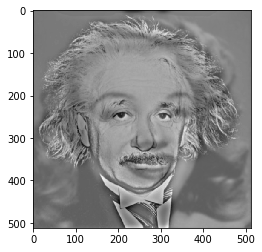

In [622]:
marilyn = readImg("marilyn.png") #ndimage.imread
einstein = readImg("albert.png")

# showImg(marilyn)
# showImg(einstein)

hybrid = hybridImage(einstein, marilyn, 11, 33, 2, True)
showImg(hybrid.real)


In [623]:
print('numpy:')
%timeit hybridImage(einstein, marilyn, 11, 33, 2, True)
print('my fft:')
%timeit hybridImage(einstein, marilyn, 11, 33, 2, False)

numpy:
615 ms ± 5.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
my fft:
3.95 s ± 7.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [624]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def f(x):
    t =  x/100
    print(t)
    hybrid = hybridImage(einstein, marilyn, 20, 20, t)
    showImg(hybrid.real)

interact(f, x=widgets.IntSlider(min=0,max=500,step=10,value=230));


interactive(children=(IntSlider(value=230, description='x', max=500, step=10), Output()), _dom_classes=('widge…